In [1]:
# specify our batch size, number of epochs, and learning rate
batch_size = 20
EPOCHS = 20
LR = 1e-4

In [34]:
from torch.utils.data import random_split
import pytorch_lightning as pl
from torch import nn, optim
from torchvision.models import resnet18, mobilenet_v3_small
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import accuracy, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from numpy import dot
from numpy.linalg import norm
import random
from ast import literal_eval
import torch
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as T

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(2021)

In [4]:
def generate_preds(loader):
    with torch.no_grad():
        for i, (images,labels) in enumerate(loader):
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
    return preds, labels

def plot_confusion_matrix(confusion_matrix_stats, target_names):
    df_cm = pd.DataFrame(confusion_matrix_stats, target_names, target_names)
    plt.figure(figsize=(20,14)) # create empty figure to draw on
    sns.set(font_scale=1.2) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}) # font size
    plt.show()

def generate_scores(loader):
    with torch.no_grad():
        for i, (images,labels) in enumerate(loader):
            outputs = torch.softmax(model(images), dim=-1)
    return outputs, labels

def draw_roc_curves(scores, labels, target_names):
  fpr = dict() 
  tpr = dict() 
  roc_auc = dict() 
  for i in range(9):
    labels_copy = np.where(labels == i, 1, 0) 
    fpr[i], tpr[i], _ = roc_curve(labels_copy, scores[:,i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 

  for i in range(9):
    class_name = target_names[i]
    plt.plot(fpr[i], tpr[i], label="AUC=" + str(round(roc_auc[i], 2)))
    plt.title("ROC curve for class " + class_name)
    plt.legend(loc=4)
    plt.show()

In [5]:
class ImageDataset(Dataset):

    def __init__(self, data_csv, root_folder, image_folder, augment, test):
        self.augment = augment
        self.root_folder = root_folder
        self.image_folder = image_folder
        if not test:
            self.csv = pd.read_csv(os.path.join(root_folder, data_csv))
            self.csv = self.csv[self.csv.category.isin([1,2,3,4,5,6,8,9,10,11,12,13])]
        else:
            self.csv = data_csv
        self.image_list = list(self.csv['image'])
        self.bbox_list = list(self.csv['bbox'])
        self.category_list = list(self.csv['category'])


    def get_object(self, path, bbox):
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        crop_img = image[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
        return Image.fromarray(crop_img)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        bbox = literal_eval(self.bbox_list[idx])
        filename = os.path.join(self.root_folder, self.image_folder, self.image_list[idx])
        image = self.get_object(filename, bbox)
        image = TF.pil_to_tensor(image)
        image = torch.div(image, 255)
        normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        image = normalize(image)
        if self.augment == 1:
            transforms = T.Compose([
                T.RandomCrop(size = (int(bbox[3] * 0.6), int(bbox[2] * 0.6))),
            ])
            image = transforms(image)
            h, w = image.shape[1:]
            if w > h:
                padding = [0,(w - h) // 2]
            else:
                padding = [(h - w) // 2, 0]
            image = TF.pad(image, padding)
            image = TF.resize(image, [224,224])
        elif self.augment == 2:
            transforms = T.Compose([
                T.RandomRotation(degrees=(0, 360)),
            ])
            image = transforms(image)
            h, w = image.shape[1:]
            if w > h:
                padding = [0,(w - h) // 2]
            else:
                padding = [(h - w) // 2, 0]
            image = TF.pad(image, padding)
            image = TF.resize(image, [224,224])
        else:
            if bbox[2] > bbox[3]:
                padding = [0,(int(bbox[2]) - int(bbox[3])) // 2]
            else:
                padding = [(int(bbox[3]) - int(bbox[2])) // 2, 0]
            image = TF.pad(image, padding)
            image = TF.resize(image, [224,224])
        return [image.float(), self.category_list[idx] - 1]

In [122]:
dataset = ImageDataset('data.csv', '/home/melehean/Important_Stuff/hackatron/Projekt', 'reference_images_part1', 0, False)
dataset_val = ImageDataset('valid.csv', '/home/melehean/Important_Stuff/hackatron/Projekt', 'images_part1_valid', 0, False)
dataset_aug1 = ImageDataset('data.csv', '/home/melehean/Important_Stuff/hackatron/Projekt', 'reference_images_part1', 1, False)
dataset_aug2 = ImageDataset('data.csv', '/home/melehean/Important_Stuff/hackatron/Projekt', 'reference_images_part1', 2, False)
dataset = torch.utils.data.ConcatDataset([dataset,dataset_aug1,dataset_aug2])

print(len(dataset))

validate_size = len(dataset_val)

train_loader = DataLoader(dataset, batch_size = batch_size, num_workers = 12, shuffle = True, pin_memory = True)
val_loader = DataLoader(dataset_val, batch_size = batch_size, num_workers = 12, shuffle = False, pin_memory = True)

432


In [7]:
class ImageClassifier(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.learning_rate = LR
        self.loss = nn.CrossEntropyLoss()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 28)

    def forward(self, input):
        output=self.model(input)
        return output

    def training_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs) 
      preds = torch.argmax(outputs, dim=1)

      train_accuracy = accuracy(preds, targets)
      train_f1_score = f1_score(preds, targets)
      loss = self.loss(outputs, targets)

      self.log('train_accuracy', train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
      self.log('train_f1_score', train_f1_score, on_step=False, on_epoch=True)
      self.log('train_loss', loss, on_step=False, on_epoch=True)

      return {"loss":loss, 'train_accuracy': train_accuracy, "train_f1_score": train_f1_score}

    def test_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self.forward(inputs)
      preds = torch.argmax(outputs, dim=1)

      test_accuracy = accuracy(preds, targets)
      test_f1_score = f1_score(preds, targets)

      self.log('total_test_accuracy', test_accuracy, on_step=False, on_epoch=True)
      self.log('total_test_f1_score', test_f1_score, on_step=False, on_epoch=True)

      return {"test_accuracy": test_accuracy, "test_f1_score": test_f1_score}

    def validation_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self.forward(inputs)
      preds = torch.argmax(outputs, dim=1)

      val_accuracy = accuracy(preds, targets)
      val_f1_score = f1_score(preds, targets)
      loss = self.loss(outputs, targets)

      self.log('validation_accuracy', val_accuracy, prog_bar=True, on_step=False, on_epoch=True)
      self.log('validation_loss', loss, on_step=False, on_epoch=True)
      self.log('validation f1 score', val_f1_score, on_step=False, on_epoch=True)

      return {"validation_loss":loss, "validation_accuracy":val_accuracy, "validation_f1_score": val_f1_score}

    def configure_optimizers(self):
      params = self.parameters()
      optimizer = optim.Adam(params=params, lr = self.learning_rate)
      return optimizer

In [8]:
# saves a file like: my/path/sample-mnist-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor="validation_accuracy",
    dirpath="/home/melehean/Important_Stuff/hackatron/Projekt/models/",
    filename="sample-mnist-{epoch:02d}-{validation_accuracy:.2f}",
    save_top_k=5,
    mode="max",
)

In [9]:
early_stop_callback = EarlyStopping(monitor="validation_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max")

## **Training**

In [568]:
model = ImageClassifier()

trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[checkpoint_callback]) #add checkpoint_callback to callbacks table to enable saving during training
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/melehean/pytorch-gpu/pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/melehean/Important_Stuff/hackatron/Projekt/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | ResNet           | 11.2 M
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.764    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [10]:
model = ImageClassifier.load_from_checkpoint(
    "/home/melehean/Important_Stuff/hackatron/Projekt/models/sample-mnist-epoch=03-validation_accuracy=0.59.ckpt")
model.eval()
list(model.modules())

[ImageClassifier(
   (loss): CrossEntropyLoss()
   (model): ResNet(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2

In [124]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

Launching TensorBoard...

## **Validation set**

In [12]:
trainer.validate(model, dataloaders=val_loader)

NameError: name 'trainer' is not defined

In [584]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model.model.fc = Identity()
device = torch.device("cuda:0")
model = model.to(device)
model.eval()

ImageClassifier(
  (loss): CrossEntropyLoss()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

In [585]:
embeddings = {}
for x, y in train_loader:
    output = model(x.to(device))
    output = output.cpu()
    for i, vector in enumerate(output):
        if int(y[i]) not in embeddings: embeddings[int(y[i])] = []
        embeddings[int(y[i])].append(vector.detach().numpy())

In [586]:
import numpy as np

for category in embeddings:
    embeddings[category] = np.mean(embeddings[category], axis=0)

In [ ]:

total = 0
correct = 0
categories = {}
y_preds = []
y_true_results = []
for x, y in val_loader:
    output = model(x.to(device))
    output = output.cpu()
    for i, vector in enumerate(output):
        max_sim = 0
        max_cat = 0
        vector = vector.detach().numpy()
        for embedding in embeddings:
            if int(y[i]) not in categories: categories[int(y[i])] = [0,0]
            cos_sim = dot(embeddings[embedding], vector)/(norm(embeddings[embedding])*norm(vector))
            if max_sim < cos_sim:
                max_sim = cos_sim
                max_cat = embedding
        if max_cat == int(y[i]):
             correct += 1
             categories[int(y[i])][0] += 1
        y_true_results.append(int(y[i]))
        y_preds.append(max_cat)
        categories[int(y[i])][1] += 1
        total += 1

In [588]:
correct/total

0.594630209191237

In [589]:
for category in categories:
    print(f'Accuracy for category {category}: {categories[category][0]/categories[category][1]}')

Accuracy for category 3: 0.5873287671232876
Accuracy for category 12: 0.3488372093023256
Accuracy for category 7: 0.8581081081081081
Accuracy for category 8: 0.5610200364298725
Accuracy for category 10: 0.6887218045112782
Accuracy for category 4: 0.6292682926829268
Accuracy for category 0: 0.26046511627906976
Accuracy for category 2: 0.7917808219178082
Accuracy for category 9: 0.907563025210084
Accuracy for category 1: 0.8237951807228916
Accuracy for category 11: 0.16412213740458015
Accuracy for category 5: 0.38095238095238093


In [590]:
total = 0
correct = 0
for category in categories:
    correct += categories[category][0]
    total += categories[category][1]
correct/total

0.594630209191237

In [591]:
categories

{3: [343, 584],
 12: [60, 172],
 7: [254, 296],
 8: [308, 549],
 10: [458, 665],
 4: [387, 615],
 0: [168, 645],
 2: [578, 730],
 9: [216, 238],
 1: [547, 664],
 11: [43, 262],
 5: [248, 651]}

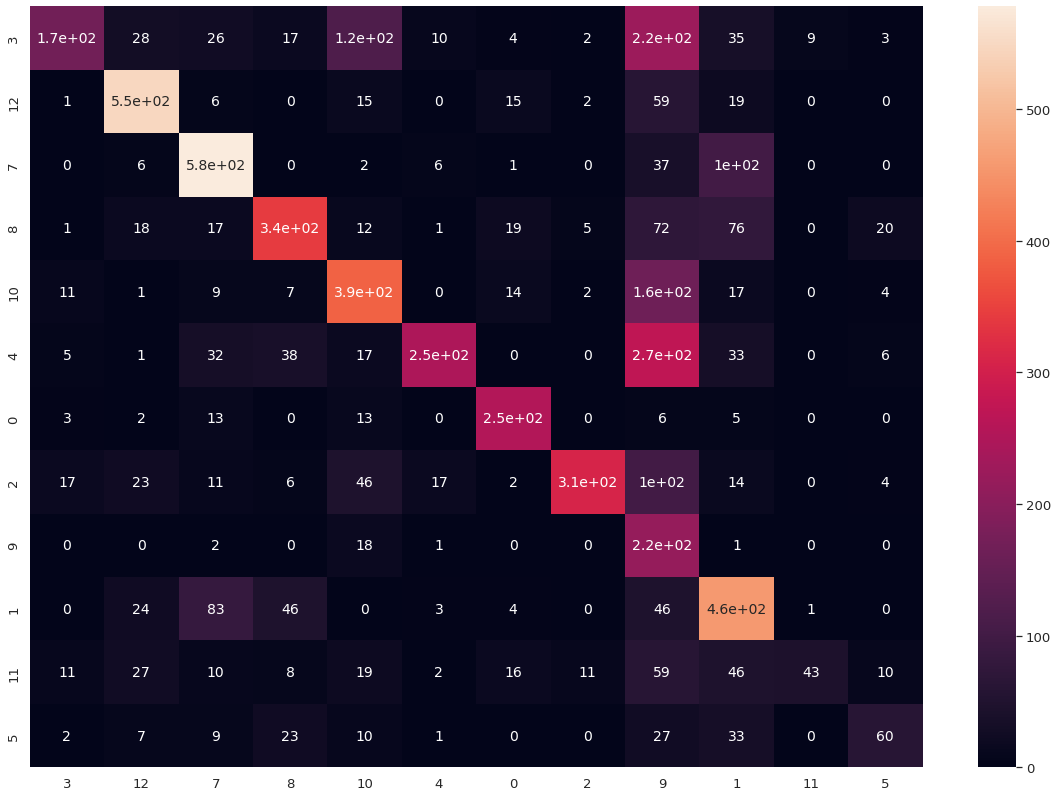

In [592]:
confusion_matrix_stats = confusion_matrix(y_true_results, y_preds)
plot_confusion_matrix(confusion_matrix_stats, target_names = categories)

In [104]:
model = ImageClassifier.load_from_checkpoint(
    "/home/melehean/Important_Stuff/hackatron/Projekt/models/sample-mnist-epoch=18-validation_accuracy=0.59.ckpt")
model.eval()
list(model.modules())

[ImageClassifier(
   (loss): CrossEntropyLoss()
   (model): ResNet(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2

In [105]:
def create_csv_from_json(json_file_path):
    file = open(json_file_path)
    all_data = json.load(file)
    data = {'id': [], 'image': [], 'bbox': [], 'category': []}

    images = {}
    annotations = []

    for image in all_data['images']:
        images[image['id']] = image['file_name']

    for annotation in all_data['annotations']:
        data['id'].append(annotation['id'])
        data['image'].append(images[annotation['image_id']])
        data['bbox'].append(annotation['bbox'])
        data['category'].append(annotation['category_id'])

    df = pd.DataFrame(data)
    df.to_csv('ref.csv', index=False)
    return df

In [114]:
import json
root_path = '/home/melehean/Important_Stuff/hackatron/Projekt/'
test_file_path = '/home/melehean/Important_Stuff/hackatron/Projekt/images_part2_test_public.json'
df = create_csv_from_json(test_file_path)

In [107]:
ref_file_path = '/home/melehean/Important_Stuff/hackatron/Projekt/reference_images_part2.json'
ref_df = create_csv_from_json(ref_file_path)
ref_dataset = ImageDataset('ref.csv', '/home/melehean/Important_Stuff/hackatron/Projekt', 'reference_images_part2', 0, False)
ref_loader = DataLoader(ref_dataset, batch_size = batch_size, num_workers = 12, shuffle = True, pin_memory = True)

In [115]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

model.model.fc = Identity()
device = torch.device("cuda:0")
model = model.to(device)
model.eval()

ImageClassifier(
  (loss): CrossEntropyLoss()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

In [116]:
embeddings = {}
for x, y in ref_loader:
    output = model(x.to(device))
    output = output.cpu()
    for i, vector in enumerate(output):
        if int(y[i]) not in embeddings: embeddings[int(y[i])] = []
        embeddings[int(y[i])].append(vector.detach().numpy())
import numpy as np

for category in embeddings:
    embeddings[category] = np.mean(embeddings[category], axis=0)

In [117]:
def get_object(path, bbox):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    crop_img = image[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    return Image.fromarray(crop_img)

In [118]:
def get_processed_image(path, bbox):
    image = get_object(path, bbox)
    image = TF.pil_to_tensor(image)
    if bbox[2] > bbox[3]:
        padding = [0,(int(bbox[2]) - int(bbox[3])) // 2]
    else:
        padding = [(int(bbox[3]) - int(bbox[2])) // 2, 0]
    image = TF.pad(image, padding)
    image = TF.resize(image, [224,224])
    image = image.float()
    return image

In [119]:
for i, row in df.iterrows():
    path = root_path + 'images_part2_test/' + row['image']
    bbox = row['bbox']
    bbox = [round(i) for i in bbox]

    image = get_processed_image(path, bbox)
    output = model(image.reshape(1,3,224,224).to(device))
    output = output.cpu()
    max_sim = 0
    max_cat = 0
    output = output.detach().numpy()
    output = output.reshape(512,)
    for embedding in embeddings:
        cos_sim = dot(embeddings[embedding], output)/(norm(embeddings[embedding])*norm(output))
        if max_sim < cos_sim:
            max_sim = cos_sim
            max_cat = embedding
    df.at[i,'category'] = max_cat
df

,id,image,bbox,category
0,1,20220414-105524.484440-scout.png,"[503.16, 284.25, 165.79, 144.13]",4
1,2,20220414-105524.484440-scout.png,"[535.83, 457.12, 91.11, 50.76]",11
2,3,20220414-105524.484440-scout.png,"[570.61, 474.68, 102.2, 33.32]",4
3,4,20220414-105524.484440-scout.png,"[633.74, 281, 58.58, 92.2]",4
4,5,20220414-105524.484440-scout.png,"[539.46, 398.62, 94.97, 58.63]",11
...,...,...,...,...
7018,16062,20220413-100017.199794-scout.png,"[664.41, 406.75, 48.48, 96.75]",11
7019,16063,20220413-100017.199794-scout.png,"[652.17, 271.25, 107.71, 114]",4
7020,16064,20220413-100017.199794-scout.png,"[575.17, 319.53, 34.73, 101.72]",4
7021,16065,20220413-100017.199794-scout.png,"[513.43, 381.25, 9.22, 114.98]",12


In [120]:
with open(test_file_path, 'r') as f:
    data = json.load(f)
    for i, value in enumerate(data['annotations']):
        data['annotations'][i]['category_id'] =  int(df[df['id']==value['id']]['category'])

#os.remove('/home/melehean/Important_Stuff/hackatron/Projekt/images_part1_test_public_dataszarks.json')
with open('/home/melehean/Important_Stuff/hackatron/Projekt/images_part2_test_public_dataszarks.json','w') as f:
    json.dump(data, f, indent=4)